In [1]:
its_jupyter_notebook = True

In [2]:
import pandas as pd
import os
import time
import numpy as np
import seaborn as sns
import pickle
import torch
from pathlib import Path
import argparse
import math
from scipy import stats
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, auc

sys.path.insert(0, '..')

from util.evaluation import load_paris_results, map_signal_to_sigmoid_range, balance_df
from util.xai import gradcam, interpolate_expl_matrix, plot_matrix
from config import *
from models.nt_classifier import build as build_model 
from util.plot_utils import plot_confidence_based_on_distance, plot_tnr_based_on_distance, quantile_bins, collect_prec_npv_based_on_confidence_level_based_on_treshold, obtain_plot, collect_results_based_on_confidence_level_based_on_percentile, plot_length_embeddings_and_rnas, plot_intarna_Enorm_curves, plot_logs, plot_ROC_based_on_confidence, obtain_auc_and_perc_in_specific_treshold, get_policies_list, plot_results_based_on_treshold, plot_results_based_on_percentile, collect_results_based_on_confidence_level_based_on_treshold, plot_confs_and_accs, collect_prec_recall_sens_npv_based_on_confidence_level_based_on_percentile, calc_acc_for_each_class, plot_roc_curves, collect_results_based_on_confidence_level_how_many1, acc_for_each_class
if its_jupyter_notebook:
    sys.argv = [''] #Remove this if it's not a jupyter notebook!

<class 'transformers.tokenization_dna.DNATokenizer'>


In [3]:
HOW = 'test'
SPECIE = 'human'


assert HOW in ['val', 'test']

assert SPECIE in ['human', 'mouse']

In [4]:
checkpoint_dir = os.path.join(ROOT_DIR, 'checkpoints', 'all_modelarch2_wrongSN_easypretrain11_paristfinetuningSPLASHval0039parisHQSPLASHval0054_NOWENHNokSN_splashPARISFINETUNINGtrainhqRICSEQval0069')

In [5]:
# Define the path to the file containing the args namespace
args_path = os.path.join(checkpoint_dir, 'args.pkl')

# Load the args namespace from the file
with open(args_path, 'rb') as f:
    args_dict = pickle.load(f)
    
#print(args_dict)
#args_dict['policies_train'][0].height_probabilities
#args_dict['policies_train'][0].height_bins

In [6]:
test500 = pd.read_csv(os.path.join(metadata_dir, f'{HOW}500.csv'))
df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt_HQ.csv'))
assert test500.shape[0] == df_nt[['couples', 'interacting']].merge(test500, on = 'couples').shape[0]
test500 = df_nt[['couples', 'interacting', 'where', 'where_x1', 'where_y1', 'simple_repeats', 'sine_alu', 'low_complex']].merge(test500, on = 'couples')
id_cds_cds = set(test500[test500['where'] == 'CDS-CDS'].couples)

res = load_paris_results(checkpoint_dir, test500, HOW, SPECIE)

In [7]:
print(classification_report(res.ground_truth, res.prediction))

              precision    recall  f1-score   support

           0       0.81      0.85      0.83     14449
           1       0.45      0.39      0.42      4633

    accuracy                           0.74     19082
   macro avg       0.63      0.62      0.62     19082
weighted avg       0.72      0.74      0.73     19082



# Depend on the lenght?

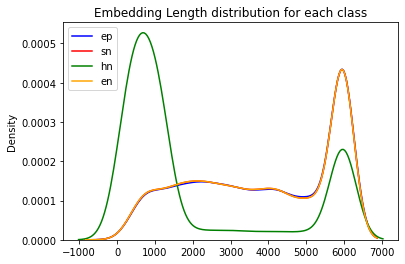

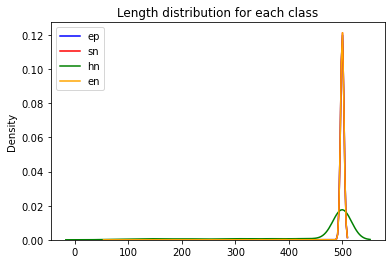

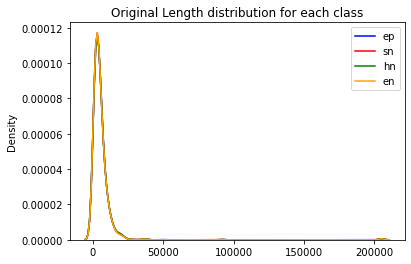

In [9]:
len_emb1 = res.g1.str.extractall('(.*)_(.*)_(.*)').reset_index(drop = True)
len_emb2 = res.g2.str.extractall('(.*)_(.*)_(.*)').reset_index(drop = True)
res['len_emb1'] = len_emb1[2].astype(int) - len_emb1[1].astype(int)
res['len_emb2'] = len_emb2[2].astype(int) - len_emb2[1].astype(int)

res['emebedding_area'] = res['len_emb1'] * res['len_emb2']

plot_length_embeddings_and_rnas(res)

/data01/giorgio/ENTER/envs/dnabert/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (1,2,16,17,18,20) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


<AxesSubplot:>

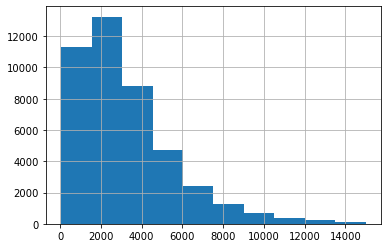

In [10]:
df_genes = pd.read_csv(os.path.join(processed_files_dir, f'df_genes.csv'))
df = pd.read_csv(os.path.join(processed_files_dir, f'paris.csv'))
df_genes = df_genes[df_genes.gene_id.isin(set(df.gene1).union(df.gene2))].reset_index(drop = True)
df_genes[df_genes.length < 15_000].length.hist()

area interval: [0, 2637128]


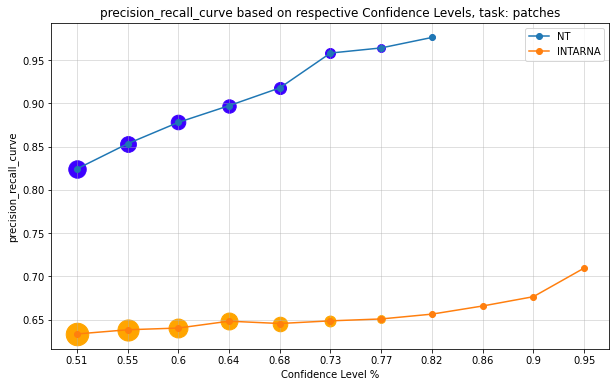



area interval: [2637128, 15237925]


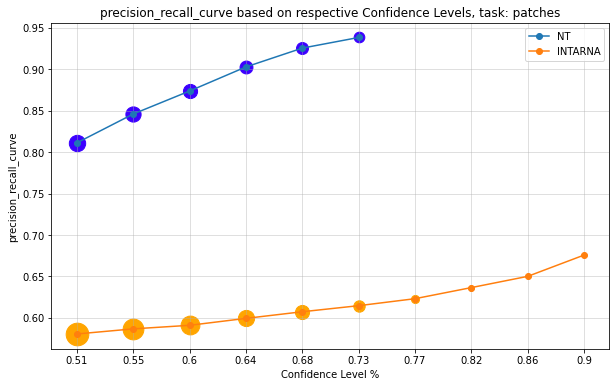



area interval: [15237925, 18792835004]


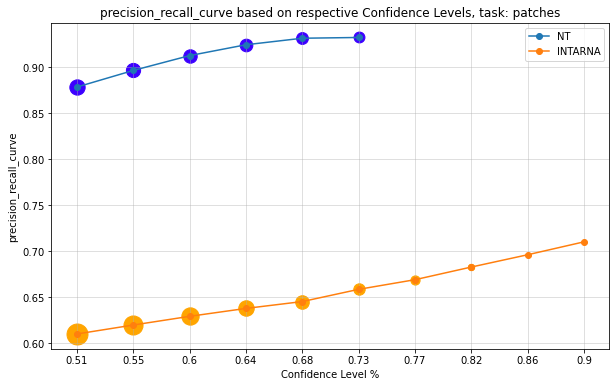

In [11]:
#create quantiles of interaction
df_int = df[(df.interacting)].reset_index(drop = True)
df_int['original_area'] = df_int.length_1 * df_int.length_2
    
area_values = np.array(df_int.original_area)


N_percentiles_area = 2

perc_values = np.linspace(10, 100, N_percentiles_area + 1)


n_values = 12
MIN_PERC = 1
plot_ens = False

task = 'patches' #interactors, patches

policies = get_policies_list(task)

balance_at_the_beginning = True
area_value2 = 0
for perc_value in perc_values:
    
    area_value = np.quantile(area_values, perc_value/100)

    area_value1 = area_value2
    area_value2 = area_value
    subset = res[(res.original_area >= area_value1) & (res.original_area <= area_value2)].reset_index(drop = True)
    subset = subset[subset.policy.isin(policies)].reset_index(drop = True)
    
    print(f'area interval: [{int(area_value1)}, {int(area_value2)}]')

    if set(subset.policy.value_counts().index) == set(policies):
        
        if balance_at_the_beginning:
            subset = balance_df(subset).reset_index(drop = True)
            
        MIN_SAMPLES = int((subset.shape[0] * MIN_PERC) / 100)
        
        plot_results_based_on_treshold(subset, task, MIN_PERC, MIN_SAMPLES, n_values = 12, size_multiplier = 10, plot_ens = False)
        
        print('\n')

perc of data in this interval:  3.0
area interval: [0, 1000000]


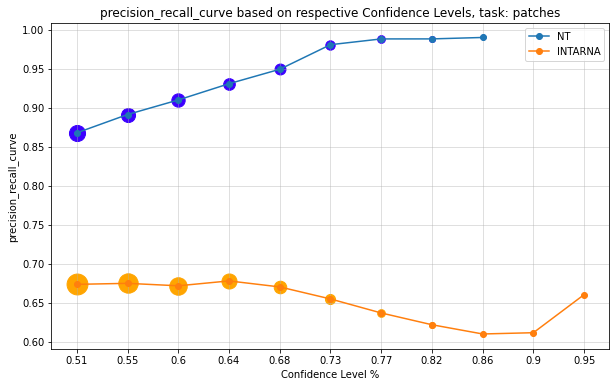



perc of data in this interval:  54.0
area interval: [1000000, 16000000]


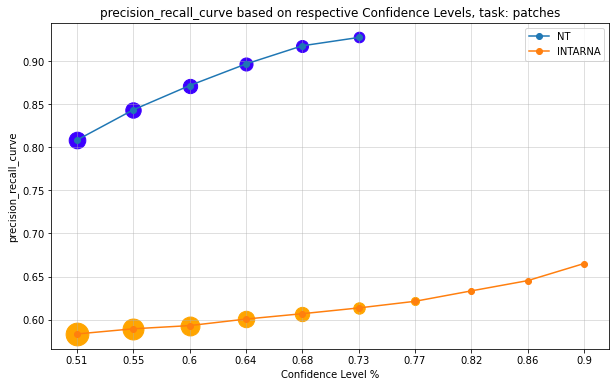



perc of data in this interval:  25.0
area interval: [16000000, 36000000]


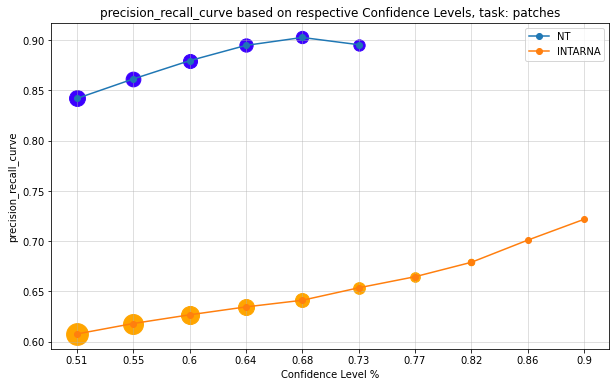



perc of data in this interval:  18.0
area interval: [36000000, 4000000000000]


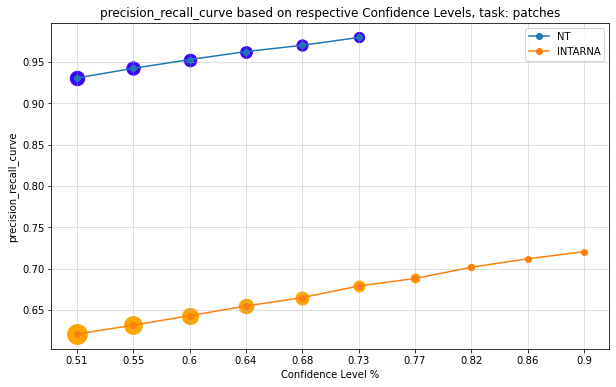

In [12]:
area_values_plot = [[0, 1_000**2], [1_000**2, 4_000**2], [4_000**2, 6_000**2], [6_000**2, 2_000_000**2]]

for (area_value1, area_value2) in area_values_plot:
    subset = res[(res.original_area >= area_value1) & (res.original_area <= area_value2)].reset_index(drop = True)
    subset = subset[subset.policy.isin(policies)].reset_index(drop = True)
    
    perc_of_total_df = df_int[(df_int.original_area >= area_value1) & (df_int.original_area <= area_value2)].shape[0]/df_int.shape[0] * 100
    print('perc of data in this interval: ', np.round(perc_of_total_df))
    
    print(f'area interval: [{int(area_value1)}, {int(area_value2)}]')

    if set(subset.policy.value_counts().index) == set(policies):
        
        
        if balance_at_the_beginning:
            subset = balance_df(subset).reset_index(drop = True)
            
        MIN_SAMPLES = int((subset.shape[0] * MIN_PERC) / 100)
        
        plot_results_based_on_treshold(subset, task, MIN_PERC, MIN_SAMPLES, n_values = 12, size_multiplier = 10, plot_ens = plot_ens)
        
        print('\n')

# PLOTS

### Log plots

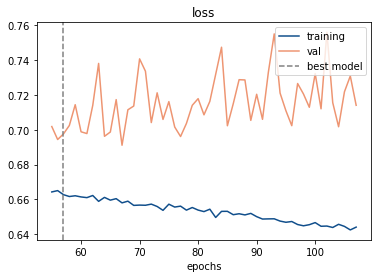

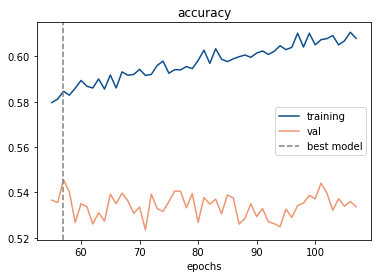

In [13]:
if os.path.isfile(os.path.join(checkpoint_dir, 'log.txt')):
    log = pd.read_json(Path(os.path.join(checkpoint_dir, 'log.txt')), lines=True)
    best_model = log.iloc[np.argmax(log.test_accuracy)].epoch
    for metric in ['loss', 'accuracy']:
        plot_logs(log, metric, best_model = best_model)

## Metrics

In [14]:
print(res.prediction.value_counts())
print('\n')
print(res.ground_truth.value_counts())

0    15055
1     4027
Name: prediction, dtype: int64


0    14449
1     4633
Name: ground_truth, dtype: int64


In [15]:
n_conf = 10

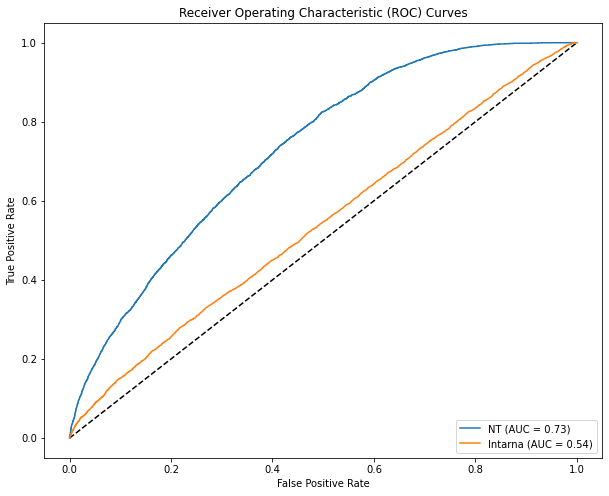

In [16]:
#obtain_plot(balance_df(res), n_original_df = res.shape[0], title = 'Metrics', n_conf = n_conf)
plot_roc_curves([{'prob': res.probability, 'model_name': 'NT'},
                 {'prob': abs(res.E_norm), 'model_name': 'Intarna'}
                ], res.ground_truth)

In [17]:
# no_pc = res[(res['gene1_pc'] == False)|(res['gene2_pc'] == False)]

# obtain_plot(balance_df(no_pc), n_original_df = res.shape[0], title = f'Metrics: At least one is no protein coding', n_conf = n_conf)

0.56262896611267


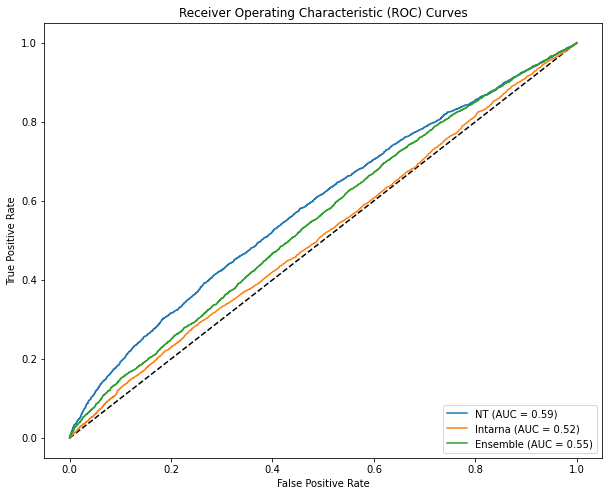

In [18]:
subset_test_nt_sampled = os.path.join(rna_rna_files_dir, f"gene_pairs_{HOW}_sampled_nt_HQ.txt")
with open(subset_test_nt_sampled, "rb") as fp:  # Unpickling
    subset_test_nt_sampled = pickle.load(fp)
    
easypos_smartneg_sampled = res[res.id_sample.isin(subset_test_nt_sampled)]
easypos_smartneg_sampled = balance_df(easypos_smartneg_sampled)
print((easypos_smartneg_sampled.prediction == easypos_smartneg_sampled.ground_truth).sum()/easypos_smartneg_sampled.shape[0])
#obtain_plot(easypos_smartneg_sampled, n_original_df = res.shape[0], title = f'Metrics: HQ (interaction length) SN VS EP recall is the accuracy of easypos, specificity is the accuracy of smartneg ',  n_conf = n_conf, excluding_treshold = 0.05)

plot_roc_curves([{'prob': easypos_smartneg_sampled.probability, 'model_name': 'NT'},
                 {'prob': abs(easypos_smartneg_sampled.E_norm), 'model_name': 'Intarna'},
                 {'prob': abs(easypos_smartneg_sampled.ensemble_score), 'model_name': 'Ensemble'},
                ], easypos_smartneg_sampled.ground_truth)

In [19]:
# how = 'fisher'

# TEST = False

# def calc_test(ep, list_id, how = 'chi2'):
    
#     sr = ep[ep.id_sample.isin(list_id)]
#     no_sr = ep[~ep.id_sample.isin(list_id)]
    
#     a = sr[sr.prediction == 1].shape[0]
#     b = no_sr[no_sr.prediction == 1].shape[0]
#     c = sr[sr.prediction == 0].shape[0]
#     d = no_sr[no_sr.prediction == 0].shape[0]
#     test(a, b, c, d, how = how)

# def test(a, b, c, d, how):
#     # Crea una tabella di contingenza tra veri positivi e falsi negativi rispetto a SIMPLE_REPEAT
#     # Ad esempio, supponiamo che tu abbia i seguenti dati:
#     #           | SIMPLE_REPEAT = True  | SIMPLE_REPEAT = False
#     # ----------------------------------------------
#     # Veri Positivi   |       a              |       b
#     # Falsi Negativi  |       c              |       d


#     # Crea la tabella di contingenza
#     observed = np.array([[a, b], [c, d]])
    
#     if how=='chi2':
#         # Esegue il test del chi-quadro per l'indipendenza
#         chi2, p, _, _ = chi2_contingency(observed)

#     else:
#         odds_ratio, p = fisher_exact([[a, b], [c, d]])
        
#     # Valuta la significatività
#     alpha = 0.05
#     if p < alpha:
#         print(f"Il test è statisticamente significativo (p = {np.round(p, 2)}).")
#         print("Ci sono evidenze di un'associazione tra Veri Positivi/Falsi Negativi e Variabile (es.Simple Repeat).")
#     else:
#         print(f"Il test non è statisticamente significativo (p = {np.round(p, 2)}).")

        
# if TEST:
#     # TODO: FAI TEST DI FISHER SU QUESTI

#     #simple_repeats_id, sine_alu_id, low_complex_id
#     ep = res[(res.policy == 'easypos')]
#     print(f'easypos accuracy: {ep[ep.prediction == 1].shape[0]/ep.shape[0]}')

#     sr = ep[ep.id_sample.isin(simple_repeats_id)]
#     print(f'\n simple repeat accuracy: {sr[sr.prediction == 1].shape[0]/sr.shape[0]}. The # of simple repeat samples is {np.round(sr.shape[0]/ep.shape[0] * 100, 2)}% of the positives.')
#     calc_test(ep, simple_repeats_id, how = how)


#     sa = ep[ep.id_sample.isin(sine_alu_id)]
#     print(f'\n sine alu accuracy: {sa[sa.prediction == 1].shape[0]/sa.shape[0]}. The # of simple repeat samples is {np.round(sa.shape[0]/ep.shape[0] * 100, 2)}% of the positives.')
#     calc_test(ep, sine_alu_id, how = how)


#     lc = ep[ep.id_sample.isin(low_complex_id)]
#     print(f'\n low complexity accuracy: {lc[lc.prediction == 1].shape[0]/lc.shape[0]}. The # of simple repeat samples is {np.round(lc.shape[0]/ep.shape[0] * 100, 2)}% of the positives.')
#     calc_test(ep, low_complex_id, how = how)


#     print('\n ------ HQ ------ \n')

#     ep = easypos_smartneg_sampled[(easypos_smartneg_sampled.policy == 'easypos')]
#     print(f'\n easypos accuracy: {ep[ep.prediction == 1].shape[0]/ep.shape[0]}')

#     sr = ep[ep.id_sample.isin(simple_repeats_id)]
#     print(f'\n simple repeat accuracy: {sr[sr.prediction == 1].shape[0]/sr.shape[0]}. The # of simple repeat samples is {np.round(sr.shape[0]/ep.shape[0] * 100, 2)}% of the positives.')
#     calc_test(ep, simple_repeats_id, how = how)

#     sa = ep[ep.id_sample.isin(sine_alu_id)]
#     print(f'\n sine alu accuracy: {sa[sa.prediction == 1].shape[0]/sa.shape[0]}. The # of simple repeat samples is {np.round(sa.shape[0]/ep.shape[0] * 100, 2)}% of the positives.')
#     calc_test(ep, sine_alu_id, how = how)

#     lc = ep[ep.id_sample.isin(low_complex_id)]
#     print(f'\n low complexity accuracy: {lc[lc.prediction == 1].shape[0]/lc.shape[0]}. The # of simple repeat samples is {np.round(lc.shape[0]/ep.shape[0] * 100, 2)}% of the positives.')
#     calc_test(ep, low_complex_id, how = how)

0.5623742715303259


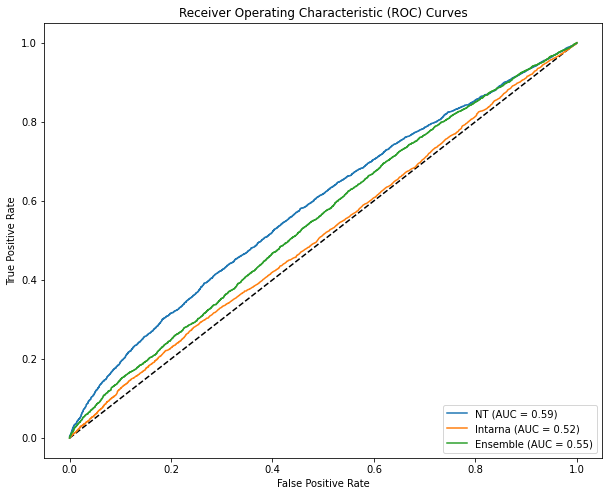

In [20]:
subset_test_nt_sampled = os.path.join(rna_rna_files_dir, f"gene_pairs_{HOW}_HQ.txt")
with open(subset_test_nt_sampled, "rb") as fp:  # Unpickling
    subset_test_nt_sampled = pickle.load(fp)
    
all_val = res[res.couples.isin(subset_test_nt_sampled)]
assert all_val.shape[0] == res.shape[0]
easypos_smartneg = all_val[all_val.policy.isin(['smartneg', 'easypos'])]

easypos_smartneg_balanced = balance_df(easypos_smartneg)

print((easypos_smartneg_balanced.prediction == easypos_smartneg_balanced.ground_truth).sum()/easypos_smartneg_balanced.shape[0])


#obtain_plot(easypos_smartneg_balanced, n_original_df = res.shape[0], title = f'Metrics: recall is the accuracy of easypos, specificity is the accuracy of smartneg',  n_conf = n_conf, excluding_treshold = 0.05)

plot_roc_curves([{'prob': easypos_smartneg_balanced.probability, 'model_name': 'NT'},
                 {'prob': abs(easypos_smartneg_balanced.E_norm), 'model_name': 'Intarna'},
                 {'prob': abs(easypos_smartneg_balanced.ensemble_score), 'model_name': 'Ensemble'},
                ], easypos_smartneg_balanced.ground_truth)

In [21]:
print('ENSEMBLE METRICS')
#obtain_plot(easypos_smartneg_balanced, n_original_df = res.shape[0], title = f'Metrics: recall is the accuracy of easypos, specificity is the accuracy of smartneg',  n_conf = n_conf, excluding_treshold = 0.05, ensemble = True)

ENSEMBLE METRICS


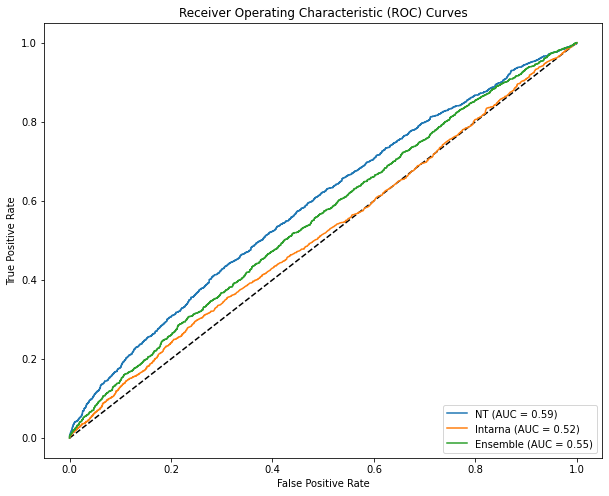

In [22]:
full_length = easypos_smartneg[(easypos_smartneg.original_length1 <= MAX_RNA_SIZE)&(easypos_smartneg.original_length2 <= MAX_RNA_SIZE)]
#obtain_plot(balance_df(full_length), n_original_df = res.shape[0], title = f'Metrics: Full length, recall is the accuracy of easypos, specificity is the accuracy of smartneg', n_conf = 10)
plot_roc_curves([{'prob': full_length.probability, 'model_name': 'NT'},
                 {'prob': abs(full_length.E_norm), 'model_name': 'Intarna'},
                 {'prob': abs(full_length.ensemble_score), 'model_name': 'Ensemble'},
                ], full_length.ground_truth)

0.5378306092124814


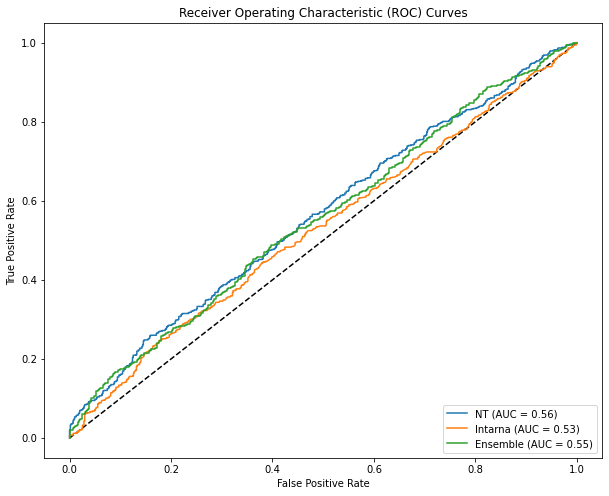

In [23]:
easypos_smartneg_balanced = balance_df(easypos_smartneg[easypos_smartneg.id_sample.isin(id_cds_cds)])

print((easypos_smartneg_balanced.prediction == easypos_smartneg_balanced.ground_truth).sum()/easypos_smartneg_balanced.shape[0])


#obtain_plot(easypos_smartneg_balanced, n_original_df = res.shape[0], title = f'Metrics: CDS-CDS recall is the accuracy of easypos, specificity is the accuracy of smartneg',  n_conf = n_conf, excluding_treshold = 0.05)

plot_roc_curves([{'prob': easypos_smartneg_balanced.probability, 'model_name': 'NT'},
                 {'prob': abs(easypos_smartneg_balanced.E_norm), 'model_name': 'Intarna'},
                 {'prob': abs(easypos_smartneg_balanced.ensemble_score), 'model_name': 'Ensemble'},
                ], easypos_smartneg_balanced.ground_truth)

0.5663989898989898


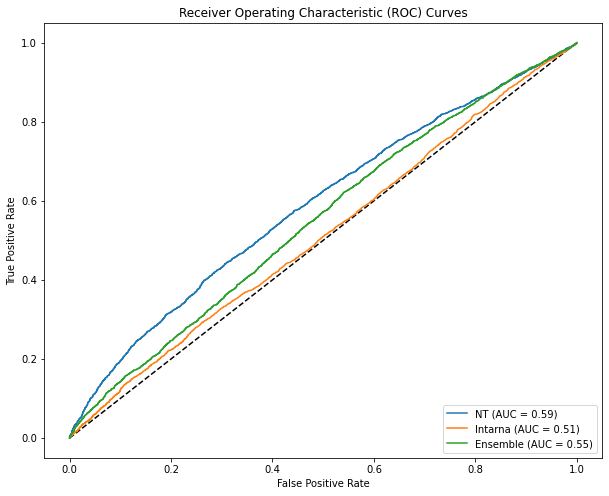

In [24]:
easypos_smartneg_balanced = balance_df(easypos_smartneg[~easypos_smartneg.id_sample.isin(id_cds_cds)])

print((easypos_smartneg_balanced.prediction == easypos_smartneg_balanced.ground_truth).sum()/easypos_smartneg_balanced.shape[0])


#obtain_plot(easypos_smartneg_balanced, n_original_df = res.shape[0], title = f'Metrics: NO CDS-CDS recall is the accuracy of easypos, specificity is the accuracy of smartneg',  n_conf = n_conf, excluding_treshold = 0.05)

plot_roc_curves([{'prob': easypos_smartneg_balanced.probability, 'model_name': 'NT'},
                 {'prob': abs(easypos_smartneg_balanced.E_norm), 'model_name': 'Intarna'},
                 {'prob': abs(easypos_smartneg_balanced.ensemble_score), 'model_name': 'Ensemble'},
                ], easypos_smartneg_balanced.ground_truth)

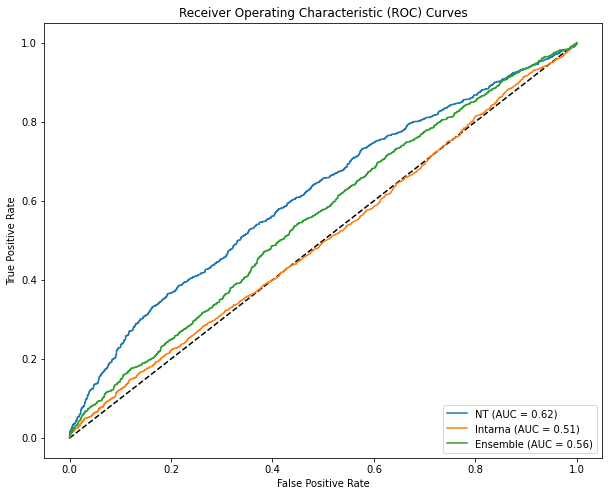

In [25]:
nopc = easypos_smartneg[(easypos_smartneg.gene1_pc == False)|(easypos_smartneg.gene2_pc == False)]

#obtain_plot(balance_df(nopc), n_original_df = res.shape[0], title = f'Metrics: recall is the accuracy of easypos, specificity is the accuracy of smartneg, at least one is no protein coding',  n_conf = n_conf, excluding_treshold = 0.05)

plot_roc_curves([{'prob': nopc.probability, 'model_name': 'NT'},
                 {'prob': abs(nopc.E_norm), 'model_name': 'Intarna'},
                 {'prob': abs(nopc.ensemble_score), 'model_name': 'Ensemble'},
                ], nopc.ground_truth)

0.5745762711864407


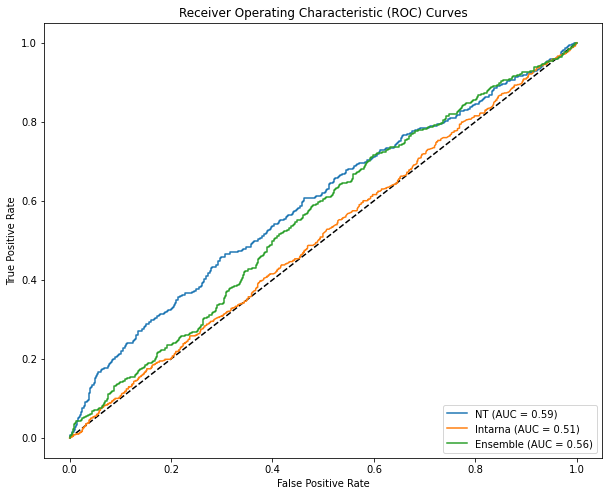

In [26]:
min_len_matrix = 5_000

big_epsn = easypos_smartneg[(easypos_smartneg.original_length1>min_len_matrix) & (easypos_smartneg.original_length2>min_len_matrix)]
big_epsn = balance_df(big_epsn)

print(big_epsn[big_epsn.ground_truth == big_epsn.prediction].shape[0]/big_epsn.shape[0])

#obtain_plot(big_epsn, n_original_df = res.shape[0], title = f'Metrics: BIG RNA-RNA recall is the accuracy of easypos, specificity is the accuracy of smartneg',  n_conf = n_conf, excluding_treshold = 0.05)

plot_roc_curves([{'prob': big_epsn.probability, 'model_name': 'NT'},
                 {'prob': abs(big_epsn.E_norm), 'model_name': 'Intarna'},
                 {'prob': abs(big_epsn.ensemble_score), 'model_name': 'Ensemble'},
                ], big_epsn.ground_truth)

0.5737005649717514


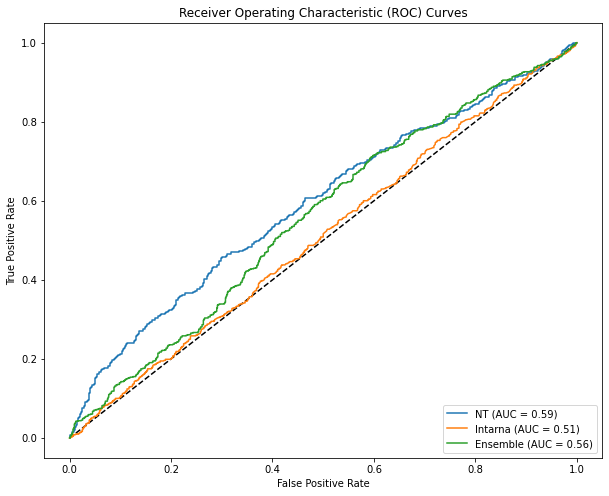

In [27]:
min_len_matrix = 5_000

big_epsn = easypos_smartneg[(easypos_smartneg.len_emb1>min_len_matrix) & (easypos_smartneg.len_emb2>min_len_matrix)]
big_epsn = balance_df(big_epsn)

print(big_epsn[big_epsn.ground_truth == big_epsn.prediction].shape[0]/big_epsn.shape[0])

#obtain_plot(big_epsn, n_original_df = res.shape[0], title = f'Metrics: BIG Embeddings. Recall is the accuracy of easypos, specificity is the accuracy of smartneg',  n_conf = n_conf, excluding_treshold = 0.05)

plot_roc_curves([{'prob': big_epsn.probability, 'model_name': 'NT'},
                 {'prob': abs(big_epsn.E_norm), 'model_name': 'Intarna'},
                 {'prob': abs(big_epsn.ensemble_score), 'model_name': 'Ensemble'},
                ], big_epsn.ground_truth)

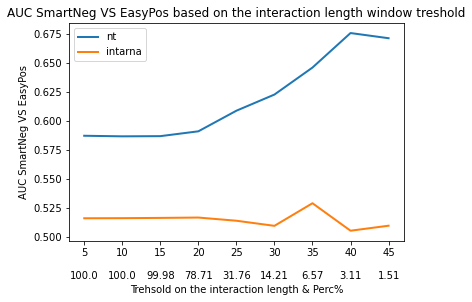

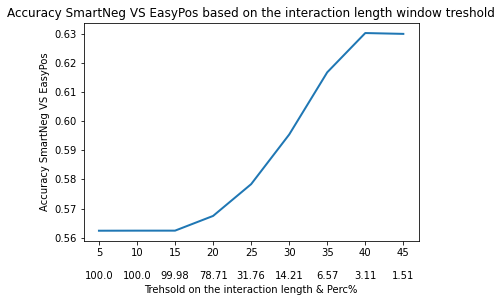

In [28]:
MIN_PERC = 1

def obtain_auc_and_perc(treshold, res, test500, balance = True, intarna = False):
    original_res_shape = res.shape[0]
    #take only big windows
    subset = test500[ (abs(test500.seed_x1 - test500.seed_x2) >treshold) & (abs(test500.seed_y1 - test500.seed_y2) > treshold) ]
    res = res[res.id_sample.isin(subset.couples)]
    
    perc = np.round((res.shape[0] / original_res_shape)*100, 2)
    
    if balance:
        res = balance_df(res)
    
    if intarna:
        fpr, tpr, _ = roc_curve(abs(1 - res.ground_truth), res.E_norm)
        roc_auc = auc(fpr, tpr)
    else:
        fpr, tpr, _ = roc_curve(res.ground_truth, res.probability)
        roc_auc = auc(fpr, tpr)
    
    return roc_auc, perc

def obtain_acc_and_perc(treshold, res, test500, balance = True):
    original_res_shape = res.shape[0]
    #take only big windows
    subset = test500[ (abs(test500.seed_x1 - test500.seed_x2) >treshold) & (abs(test500.seed_y1 - test500.seed_y2) > treshold) ]
    res = res[res.id_sample.isin(subset.couples)]
    
    perc = np.round((res.shape[0] / original_res_shape)*100, 2)
    
    if balance:
        res = balance_df(res)

    acc = (res.prediction == res.ground_truth).sum()/res.shape[0]
    return acc, perc

tresholds = np.linspace(5, 50, 10).astype(int)
accuracies = []
aucs_nt = []
aucs_intarna = []
percs = []
for treshold in tresholds:
    acc, perc = obtain_acc_and_perc(treshold, easypos_smartneg, test500)
    if perc > MIN_PERC:
        accuracies.append(acc)
        roc_auc, perc = obtain_auc_and_perc(treshold, easypos_smartneg, test500, balance = True, intarna = False)
        aucs_nt.append(roc_auc)
        roc_auc, perc = obtain_auc_and_perc(treshold, easypos_smartneg, test500, balance = True, intarna = True)
        aucs_intarna.append(roc_auc)
        percs.append(perc)

merged_x_axis = []
for i in range(0, len(percs)):
    tuple_to_print = (np.round(tresholds[i],2), np.round(percs[i], 2))
    merged_x_axis.append('\n\n'.join(str(x) for x in tuple_to_print))

plt.title('AUC SmartNeg VS EasyPos based on the interaction length window treshold')

plt.plot(merged_x_axis, aucs_nt, label = 'nt', linewidth=2)
plt.plot(merged_x_axis, aucs_intarna, label = 'intarna', linewidth=2)

plt.xlabel(f"Trehsold on the interaction length & Perc%")
plt.ylabel(f"AUC SmartNeg VS EasyPos")
plt.legend()

plt.show()


merged_x_axis = []
for i in range(0, len(percs)):
    tuple_to_print = (np.round(tresholds[i],2), np.round(percs[i], 2))
    merged_x_axis.append('\n\n'.join(str(x) for x in tuple_to_print))

plt.title('Accuracy SmartNeg VS EasyPos based on the interaction length window treshold')

plt.plot(merged_x_axis, accuracies, label = 'accuracy', linewidth=2)

plt.xlabel(f"Trehsold on the interaction length & Perc%")
plt.ylabel(f"Accuracy SmartNeg VS EasyPos")

plt.show()

0.6166013071895425


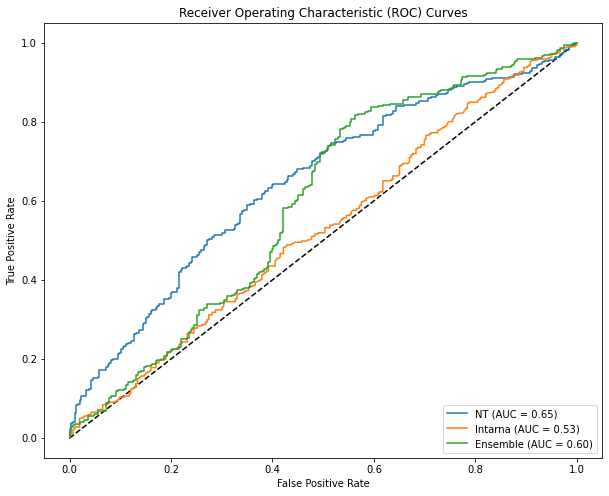

In [29]:
HQ_TRESHOLD = 35

subset = test500[ (abs(test500.seed_x1 - test500.seed_x2) >HQ_TRESHOLD) & (abs(test500.seed_y1 - test500.seed_y2) > HQ_TRESHOLD) ]
easypos_smartneg_HQ = easypos_smartneg[easypos_smartneg.id_sample.isin(subset.couples)]


assert set(easypos_smartneg_HQ.policy.value_counts().index) == set(['smartneg', 'easypos'])

easypos_smartneg_HQ_balanced = balance_df(easypos_smartneg_HQ)

print((easypos_smartneg_HQ_balanced.prediction == easypos_smartneg_HQ_balanced.ground_truth).sum()/easypos_smartneg_HQ_balanced.shape[0])


#obtain_plot(easypos_smartneg_HQ_balanced, n_original_df = res.shape[0], title = f'Metrics: [HQ] recall is the accuracy of easypos, specificity is the accuracy of smartneg',  n_conf = n_conf, excluding_treshold = 0.05)

plot_roc_curves([{'prob': easypos_smartneg_HQ_balanced.probability, 'model_name': 'NT'},
                 {'prob': abs(easypos_smartneg_HQ_balanced.E_norm), 'model_name': 'Intarna'},
                 {'prob': abs(easypos_smartneg_HQ_balanced.ensemble_score), 'model_name': 'Ensemble'},
                ], easypos_smartneg_HQ_balanced.ground_truth)

In [30]:
hn = res[(res.policy == 'hardneg')]

if hn.shape[0]>0:
    print(hn[hn.ground_truth == hn.prediction].shape[0]/hn.shape[0])
    
    
easy = res[(res.policy == 'easyneg')]
print(easy[easy.ground_truth == easy.prediction].shape[0]/easy.shape[0])


ep = res[(res.policy == 'easypos')]
print(ep[ep.ground_truth == ep.prediction].shape[0]/ep.shape[0])


sn = res[(res.policy == 'smartneg')]
print(sn[sn.ground_truth == sn.prediction].shape[0]/sn.shape[0])

0.9443125404705375
0.8632844335778321
0.3889488452406648
0.7359413202933985


0.646505503993093


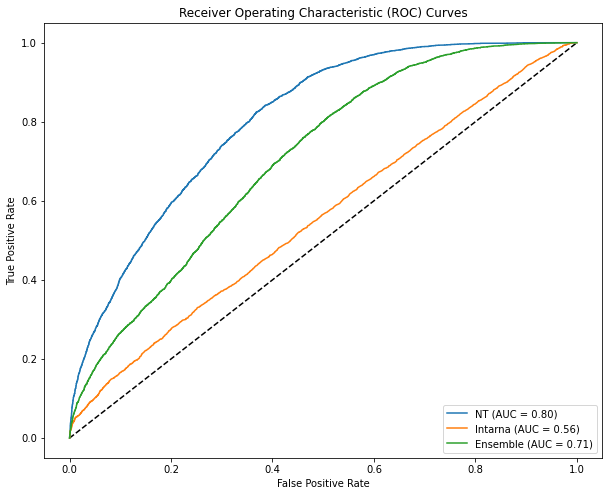

In [31]:
ephnen = res[(res.policy == 'easyneg')|(res.policy == 'easypos')|(res.policy == 'hardneg')]

ephnen_sampled = balance_df(ephnen)

print(ephnen_sampled[ephnen_sampled.ground_truth == ephnen_sampled.prediction].shape[0]/ephnen_sampled.shape[0])
#obtain_plot(ephnen_sampled, n_original_df = res.shape[0], title = f'Metrics: specificity is the accuracy of easyneg+hardneg, recall is the accuracy of easypos', n_conf = n_conf)

plot_roc_curves([{'prob': ephnen_sampled.probability, 'model_name': 'NT'},
                 {'prob': abs(ephnen_sampled.E_norm), 'model_name': 'Intarna'},
                 {'prob': abs(ephnen_sampled.ensemble_score), 'model_name': 'Ensemble'},
                ], ephnen_sampled.ground_truth)

0.6947457627118644


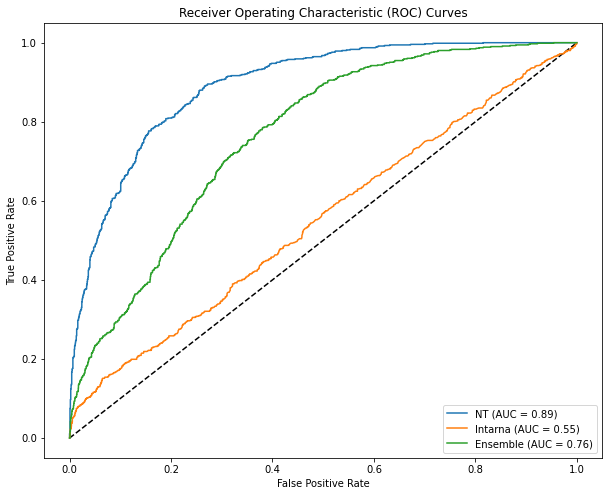

In [32]:
big_ephnen = ephnen[(ephnen.original_length1>min_len_matrix) & (ephnen.original_length2>min_len_matrix)]
big_ephnen = balance_df(big_ephnen)

print(big_ephnen[big_ephnen.ground_truth == big_ephnen.prediction].shape[0]/big_ephnen.shape[0])

#obtain_plot(big_ephnen, n_original_df = res.shape[0], title = f'Metrics: BIG RNA-RNA recall is the accuracy of easypos, specificity is the accuracy of HN, EN',  n_conf = n_conf, excluding_treshold = 0.05)

plot_roc_curves([{'prob': big_ephnen.probability, 'model_name': 'NT'},
                 {'prob': abs(big_ephnen.E_norm), 'model_name': 'Intarna'},
                 {'prob': abs(big_ephnen.ensemble_score), 'model_name': 'Ensemble'},
                ], big_ephnen.ground_truth)

0.7378193146417446


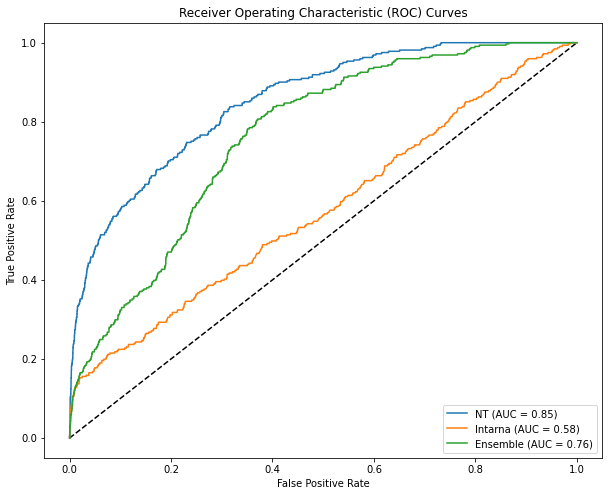

In [33]:
poshq = set(easypos_smartneg_HQ[easypos_smartneg_HQ.ground_truth == 1].id_sample)
ephnen = res[(res.policy == 'easyneg')|(res.id_sample.isin(poshq))|(res.policy == 'hardneg')]

ephnen_sampled = balance_df(ephnen)

print(ephnen_sampled[ephnen_sampled.ground_truth == ephnen_sampled.prediction].shape[0]/ephnen_sampled.shape[0])
#obtain_plot(ephnen_sampled, n_original_df = res.shape[0], title = f'Metrics: [HQ] specificity is the accuracy of easyneg+hardneg, recall is the accuracy of easypos', n_conf = n_conf, excluding_treshold = 0.05)

plot_roc_curves([{'prob': ephnen_sampled.probability, 'model_name': 'NT'},
                 {'prob': abs(ephnen_sampled.E_norm), 'model_name': 'Intarna'},
                 {'prob': abs(ephnen_sampled.ensemble_score), 'model_name': 'Ensemble'},
                ], ephnen_sampled.ground_truth)

In [34]:
# df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt_HQ.csv'))
# regex = df_nt[df_nt.couples.isin(gene_pairs_train)].couples_id.str.extractall('(.*)_(.*)').reset_index()
# df_train = regex
# df_train['g1'] = regex[0]
# df_train['g2'] = regex[1]
# df_train_genes = set(df_train['g1']).union(set(df_train['g2']))

# not_in_train = res[~(res.gene1_original.isin(df_train_genes) & res.gene2_original.isin(df_train_genes))]

In [35]:
# not_in_train_epsn = not_in_train[(not_in_train.policy == 'easypos')|(not_in_train.policy == 'smartneg')]

# not_in_train_epsn_balanced = balance_df(not_in_train_epsn)
# #obtain_plot(not_in_train_epsn_balanced, n_original_df = res.shape[0], title = f'Metrics: At least one gene is not in training, easyposVSsmarneg ', n_conf = 15, excluding_treshold = 0.2)

# plot_roc_curves([{'prob': not_in_train_epsn_balanced.probability, 'model_name': 'NT'},
#                  {'prob': abs(not_in_train_epsn_balanced.E_norm), 'model_name': 'Intarna'},
#                  {'prob': abs(not_in_train_epsn_balanced.ensemble_score), 'model_name': 'Ensemble'},
#                 ], not_in_train_epsn_balanced.ground_truth)

# Compare with Intarna

In [35]:
easypos_smartneg = res[res.policy.isin(['smartneg', 'easypos'])].reset_index(drop = True)
ephnen = res[(res.policy == 'easyneg')|(res.policy == 'easypos')|(res.policy == 'hardneg')].reset_index(drop = True)

HQ_TRESHOLD = 35
hq_couples = test500[ (abs(test500.seed_x1 - test500.seed_x2) >HQ_TRESHOLD) & (abs(test500.seed_y1 - test500.seed_y2) > HQ_TRESHOLD) ].couples
easypos_smartneg_HQ = easypos_smartneg[easypos_smartneg.id_sample.isin(hq_couples)]

ephnen_HQ = res[(res.policy == 'easyneg')|(res.id_sample.isin(poshq))|(res.policy == 'hardneg')].reset_index(drop = True)

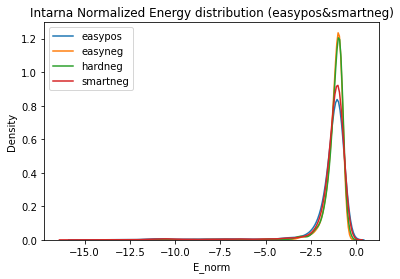

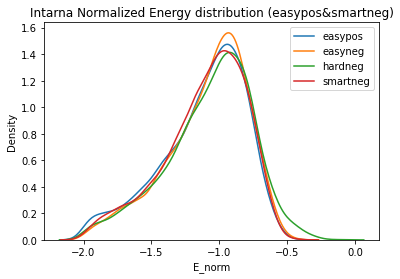

In [36]:
plot_intarna_Enorm_curves(res, treshold_plot = -100)

plot_intarna_Enorm_curves(res, treshold_plot = -2)

In [37]:
#plot_ROC_based_on_confidence(easypos_smartneg, treshold = 0.1)
#plot_ROC_based_on_confidence(easypos_smartneg, how = 'nt', treshold = 0.2)

In [38]:
n_values = 15
MIN_PERC = 0.5

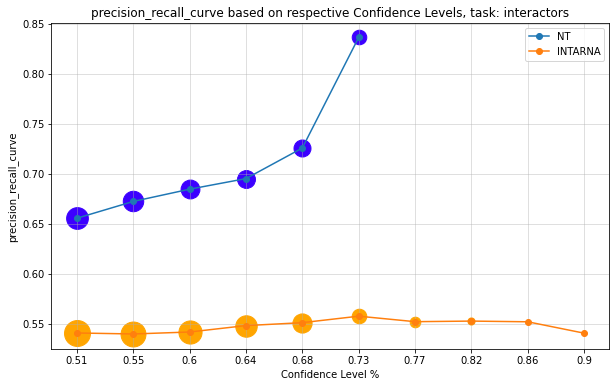

In [39]:
balance_at_the_beginning = True

task = 'interactors'
MIN_PERC = 1
order_by = 'normal' #nt, intarna, normal
hq = True

if hq:
    subset = easypos_smartneg_HQ
else:
    subset = easypos_smartneg
    
plot_ens = False

if balance_at_the_beginning:
    
    subset = balance_df(subset).reset_index(drop = True)

    MIN_SAMPLES = int((subset.shape[0] * MIN_PERC) / 100)

    plot_results_based_on_treshold(subset, task, MIN_PERC, MIN_SAMPLES, n_values = 12, size_multiplier = 10, plot_ens = plot_ens, order_by = order_by)

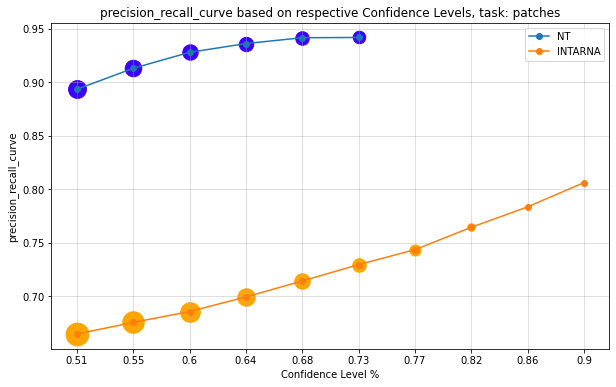

In [40]:
task = 'patches'

if hq:
    subset = ephnen_HQ
else:
    subset = ephnen
    

if balance_at_the_beginning:
    
    subset = balance_df(subset).reset_index(drop = True)

    MIN_SAMPLES = int((subset.shape[0] * MIN_PERC) / 100)

    plot_results_based_on_treshold(subset, task, MIN_PERC, MIN_SAMPLES, n_values = 12, size_multiplier = 10, plot_ens = plot_ens, order_by = order_by)

### Pathches task dependence on the distance from the interaction site

<AxesSubplot:>

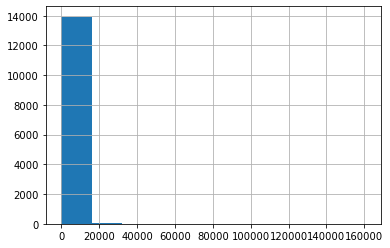

In [41]:
test500['distance_from_site'] = ( (test500['distance_x'] ** 2) + (test500['distance_y']** 2) )**(0.5) #pitagora
test500[test500.policy.isin(['hardneg', 'easyneg'])].distance_from_site.hist()

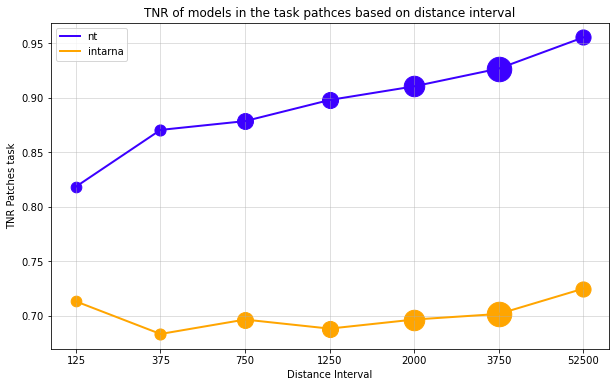

In [42]:
balance_at_the_beginning = True
bins_distance = [[0, 250], [250, 500], [500, 1_000], [1_000, 1_500], [1_500, 2_500], [2_500, 5_000], [5_000, 100_000]]
plot_tnr_based_on_distance(test500, ephnen, bins_distance)

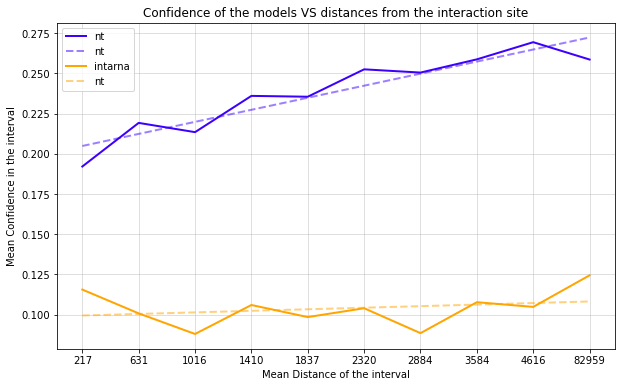

In [43]:
n_values = 10
bins_distance = quantile_bins(test500[test500.policy.isin(['hardneg', 'easyneg'])].distance_from_site, n_values)

plot_confidence_based_on_distance(test500, ephnen, bins_distance)

# How good is in predicting EN in the same embedding matrixes of SN? How good is in predicting HN in the same embedding matrixes of EP?

In [44]:
res['embedding_id'] = res.apply(lambda x: '_'.join( sorted([x.g1,x.g2]) ), axis = 1)
gb = res.groupby('embedding_id').count()
embedding_id_to_check = set(gb[gb['policy'] == 2].index)

In [45]:
res[res.embedding_id.isin(embedding_id_to_check)].policy.value_counts()

smartneg    2452
easyneg     2452
Name: policy, dtype: int64

In [46]:
easyneg_not_easy = res[(res.embedding_id.isin(embedding_id_to_check)) & (res.policy == 'easyneg')]

easy = res[(res.policy == 'easyneg')]
print(easy[easy.ground_truth == easy.prediction].shape[0]/easy.shape[0])


print(easyneg_not_easy[easyneg_not_easy.ground_truth == easyneg_not_easy.prediction].shape[0]/easyneg_not_easy.shape[0])

0.8632844335778321
0.7736541598694943


<AxesSubplot:>

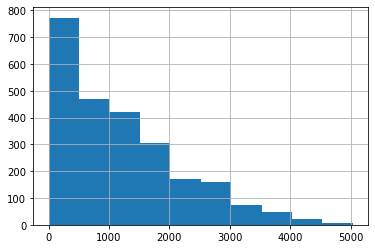

In [47]:
test500[test500.couples.isin(easyneg_not_easy.id_sample)].distance_from_site.hist()

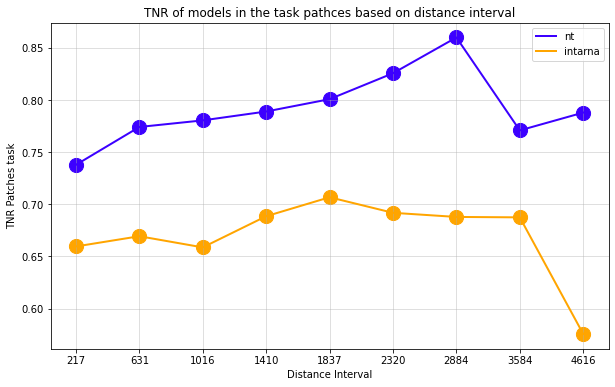

In [48]:
plot_tnr_based_on_distance(test500, easyneg_not_easy.reset_index(drop = True), bins_distance[:-1])

In [49]:
easy[~easy.id_sample.isin(easyneg_not_easy.id_sample)].shape[0]

2456

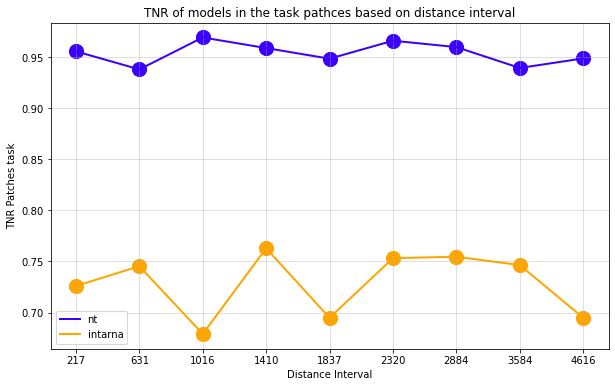

In [50]:
plot_tnr_based_on_distance(test500, easy[~easy.id_sample.isin(easyneg_not_easy.id_sample)].reset_index(drop = True), bins_distance[:-1])

### ENHN500

In [75]:
testenhn500 = pd.read_csv(os.path.join(metadata_dir, f'{HOW}ENHN500.csv'))
testenhn500['distance_from_site'] = ( (testenhn500['distance_x'] ** 2) + (testenhn500['distance_y']** 2) )**(0.5) #pitagora


enhn = pd.read_csv(os.path.join(checkpoint_dir, f'{HOW}ENHN_results500.csv')).drop('policy', axis = 1)
enhn = enhn.merge(testenhn500[['policy', 'couples']].rename({'couples':'id_sample'}, axis = 1), on = 'id_sample')
enhn.ground_truth = 0


couples_to_keep = set(res.couples)
enhn = enhn[enhn.couples.isin(couples_to_keep)].reset_index(drop = True)

enhnintarna = pd.read_csv(os.path.join(intarna_dir, f'{HOW}ENHN500', f'{HOW}ENHN.csv'), sep = ';')
enhnintarna['key'] = enhnintarna.id1 + '_' + enhnintarna.id2

# keep only the lower E_norm for each group
enhnintarna.sort_values('E_norm', ascending = False, inplace=True)
enhnintarna.drop_duplicates(subset='key', keep='first', inplace=True)
enhnintarna = enhnintarna.reset_index(drop = True)
enhnintarna['couples'] = enhnintarna.id1.str.extractall('(.*)_(.*)').reset_index(drop = True)[0]
enhnintarna['couples'] = enhnintarna['couples'].astype(int)

enhnintarna = enhnintarna.dropna()

enhn = enhn.merge(enhnintarna[['E','E_norm', 'couples']].rename({'couples':'id_sample'}, axis =1), on = 'id_sample')
enhn['original_area'] = enhn.original_length1 * enhn.original_length2

#-------------- -------------- -------------- -------------- -------------- -------------- --------------

intarna_treshold = -1.25
# Example usage
signal_range = np.linspace(-5, 0, 1000)
mapped_signal = map_signal_to_sigmoid_range(signal_range, intarna_treshold)

# Ranking the 'E_norm' column in ascending order
enhn['E_norm_conf'] = map_signal_to_sigmoid_range(enhn['E_norm'], intarna_treshold)
enhn['E_norm_conf'] = 1 - enhn['E_norm_conf']

### L agreement score in questo caso di intarna non tiene conto dello sbilanciamento dei dati... dovrei prima trovare qual e l la soglia di INTARNA dove mettere lo 0.5 e poi fare la media con lo score del nostro modello
enhn['ensemble_score'] = (enhn['probability'] + enhn['E_norm_conf']) / 2
assert enhn.ensemble_score.max() <= 1
assert enhn.ensemble_score.min() >= 0

In [76]:
print('HARDNEG')

hn = enhn[enhn.policy == 'hardneg'].reset_index(drop = True)
vc_nt = (hn.probability<0.5).value_counts()
tnr_nt = (vc_nt.loc[True])/ hn.shape[0]


vc_int = (hn.E_norm_conf < 0.5).value_counts()
tnr_intarna = (vc_int.loc[True])/ hn.shape[0]

print(f' tnr intarna = {np.round(tnr_intarna * 100, 2)} \n tnr nt = {np.round(tnr_nt * 100, 2)}')

HARDNEG
 tnr intarna = 68.95 
 tnr nt = 80.54


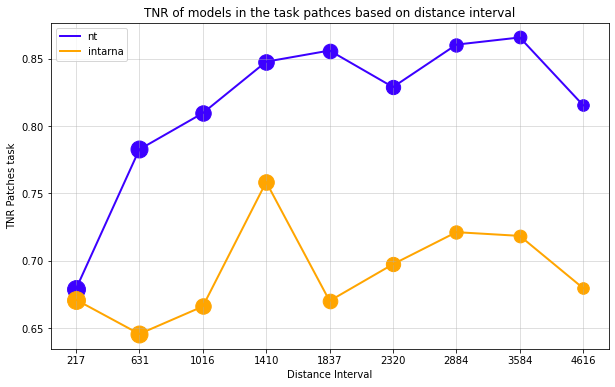

In [79]:
plot_tnr_based_on_distance(testenhn500, hn, bins_distance[:-1])

In [80]:
print('EASYNEG')

en = enhn[enhn.policy == 'easyneg'].reset_index(drop = True)
vc_nt = (en.probability<0.5).value_counts()
tnr_nt = (vc_nt.loc[True])/ en.shape[0]


vc_int = (en.E_norm_conf < 0.5).value_counts()
tnr_intarna = (vc_int.loc[True])/ en.shape[0]

print(f' tnr intarna = {np.round(tnr_intarna * 100, 2)} \n tnr nt = {np.round(tnr_nt * 100, 2)}')

EASYNEG
 tnr intarna = 70.21 
 tnr nt = 84.33


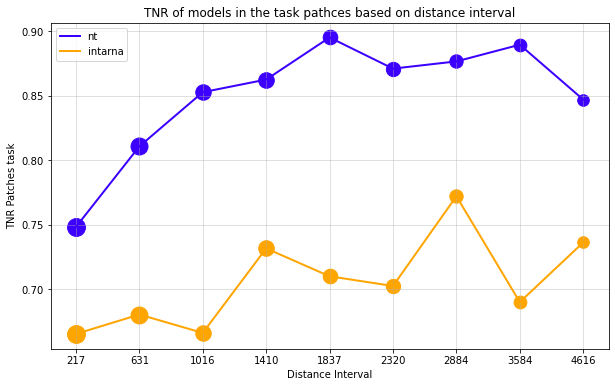

In [81]:
plot_tnr_based_on_distance(testenhn500, en, bins_distance[:-1])

# Repeats enrichment

In [ ]:
# filtered_policies = ['easypos', 'hardneg']
# if both_sr:
#     sr = res[res['simple_repeat1'] & res['simple_repeat2']]
# else:
#     sr = res[res['simple_repeat1'] | res['simple_repeat2']]
# no_sr = res[(res['simple_repeat1'] == False) & (res['simple_repeat2'] == False)] #res[res['none1'] & res['none2']] #res[(res['simple_repeat1'] == False) & (res['simple_repeat2'] == False)]

# sr = sr[sr.policy.isin(filtered_policies)].reset_index(drop = True)
# no_sr = no_sr[no_sr.policy.isin(filtered_policies)].reset_index(drop = True)

# #           | SIMPLE_REPEAT = True  | SIMPLE_REPEAT = False
# # ----------------------------------------------
# # Prediction1   |       a              |       b
# # Prediction0   |       c              |       d
# test(a = (sr.prediction == 1).sum(), 
#      b = (no_sr.prediction == 1).sum(),
#      c = (sr.prediction == 0).sum(),
#      d = (no_sr.prediction == 0).sum(),
#      how = 'fisher')
# test(a = (balanced_sr.prediction == 1).sum(), 
#      b = (balanced_no_sr.prediction == 1).sum(),
#      c = (balanced_sr.prediction == 0).sum(),
#      d = (balanced_no_sr.prediction == 0).sum(),
#      how = 'fisher')


# #             | SIMPLE_REPEAT = True | SIMPLE_REPEAT = False
# # ----------------------------------------------
# # Acc pos    |       a              |       b
# # Acc neg    |       c              |       d
# test(a = ((sr.prediction == 1) & (sr.ground_truth == 1)).sum(), 
#      b = ((no_sr.prediction == 1) & (no_sr.ground_truth == 1)).sum(),
#      c = ((sr.prediction == 0) & (sr.ground_truth == 0)).sum(),
#      d = ((no_sr.prediction == 0) & (no_sr.ground_truth == 0)).sum(),
#      how = 'fisher')

# test(a = ((balanced_sr.prediction == 1) & (balanced_sr.ground_truth == 1)).sum(), 
#      b = ((balanced_no_sr.prediction == 1) & (balanced_no_sr.ground_truth == 1)).sum(),
#      c = ((balanced_sr.prediction == 0) & (balanced_sr.ground_truth == 0)).sum(),
#      d = ((balanced_no_sr.prediction == 0) & (balanced_no_sr.ground_truth == 0)).sum(),
#      how = 'fisher')


# #             | SIMPLE_REPEAT = True | SIMPLE_REPEAT = False
# # ----------------------------------------------
# # True pos    |       a              |       b
# # False pos   |       c              |       d
# test(a = ((sr.prediction == 1) & (sr.ground_truth == 1)).sum(), 
#      b = ((no_sr.prediction == 1) & (no_sr.ground_truth == 1)).sum(),
#      c = ((sr.prediction == 1) & (sr.ground_truth == 0)).sum(),
#      d = ((no_sr.prediction == 1) & (no_sr.ground_truth == 0)).sum(),
#      how = 'fisher')

In [ ]:
feature_to_search = 'Simple_repeat' #'Simple_repeat' 'Low_complexity' 'SINE'

full_overlap = False

if full_overlap:
    suffix = 'full_'
else:
    suffix = ''

sr1 = test500[test500[f'{suffix}feature1'].apply(lambda x: feature_to_search in x)].couples
sr2 = test500[test500[f'{suffix}feature2'].apply(lambda x: feature_to_search in x)].couples

none1 = test500[test500[f'{suffix}feature1'].apply(lambda x: 'None' in x)].couples
none2 = test500[test500[f'{suffix}feature2'].apply(lambda x: 'None' in x)].couples

res['simple_repeat1'] = res.id_sample.isin(sr1)
res['simple_repeat2'] = res.id_sample.isin(sr2)
res['none1'] = res.id_sample.isin(none1)
res['none2'] = res.id_sample.isin(none2)

In [ ]:
both_sr = False

filtered_policies = ['easypos']

if both_sr:
    sr = res[res['simple_repeat1'] & res['simple_repeat2']]
else:
    sr = res[res['simple_repeat1'] | res['simple_repeat2']]
no_sr = res[(res['simple_repeat1'] == False) & (res['simple_repeat2'] == False)] #res[res['none1'] & res['none2']] #res[(res['simple_repeat1'] == False) & (res['simple_repeat2'] == False)]

sr = sr[sr.policy.isin(filtered_policies)].reset_index(drop = True)
no_sr = no_sr[no_sr.policy.isin(filtered_policies)].reset_index(drop = True)

In [ ]:
order = 'nt'

assert order in ['nt', 'intarna', 'ensemble']

if order == 'nt':
    x, y = sr['probability'], no_sr['probability']
elif order == 'intarna':
    x, y = abs(sr['E_norm']), abs(no_sr['E_norm'])
elif order == 'ensemble':
    x, y = abs(sr['ensemble_score']), abs(no_sr['ensemble_score'])

if both_sr:
    label = f'both {feature_to_search}'
else:
    label = f'at least {feature_to_search}'
    
sns.kdeplot(x, common_norm=True, label = label if both_sr else 'at least one simple repeat')
sns.kdeplot(y, common_norm=True,  label = 'no simple repeats')

plt.title(f'Score of the model')
plt.legend()
plt.show()

conf_space1, perc_1_sr = collect_results_based_on_confidence_level_how_many1(sr, how = order, MIN_PERC = MIN_PERC, balance = False, n_values = 10, space = 'linear', intarna_treshold = intarna_treshold)
conf_space2, perc_1_nosr = collect_results_based_on_confidence_level_how_many1(no_sr, how = order, MIN_PERC = MIN_PERC, balance = False, n_values = 10, space = 'linear', intarna_treshold = intarna_treshold)

set_comuni = set(conf_space1) & set(conf_space2)

conf_space = [conf_space1[i] for i in range(len(conf_space1)) if conf_space1[i] in set_comuni]
perc_1_sr = [perc_1_sr[i] for i in range(len(conf_space1)) if conf_space1[i] in set_comuni]
perc_1_nosr = [perc_1_nosr[i] for i in range(len(conf_space2)) if conf_space2[i] in set_comuni]

plt.plot(conf_space, perc_1_sr, label = feature_to_search)
plt.plot(conf_space, perc_1_nosr, label = f'no {feature_to_search}')
plt.title(f'Percentage positive predictions based on {order} Confidence Levels')
plt.legend()
plt.ylabel('Perc % predicted positives')
plt.xlabel(f"Conf%")
plt.show()

# Test di Kolmogorov-Smirnov
ks_statistic, ks_p_value = stats.ks_2samp(x, y)
print(f"Test di Kolmogorov-Smirnov:\nStatistiche KS: {ks_statistic}\nP-value: {ks_p_value}\n")

# Test di Mann-Whitney U
mwu_statistic, mwu_p_value = stats.mannwhitneyu(x, y, alternative='two-sided')
print(f"Test di Mann-Whitney U:\nStatistiche U: {mwu_statistic}\nP-value: {mwu_p_value}")

In [ ]:
df_repeats = pd.read_csv(os.path.join(processed_files_dir, 'nt_data', 'mean_embeddings', 'df_repeats.csv'))

#check to assert that all our repeats are correctly annotated
to_check = sr[(sr.simple_repeat1 == True) & (sr.simple_repeat2 == True) ]

for _, row in to_check.iterrows():

    if len(test500[test500.couples == row.id_sample]) == 1:
        row_test500 = test500[test500.couples == row.id_sample].iloc[0]
        subset_rep = df_repeats[df_repeats.gene_id == row.gene1_original]

        found1 = False
        for _, s_row in subset_rep.iterrows():
            if len(set(range(s_row.start, s_row.end)).intersection(set(range(row_test500['x1'] - 1, row_test500['x2'] + 1)))) > 0:
                found1 = True

        assert found1 == True

        subset_rep = df_repeats[df_repeats.gene_id == row.gene2_original]
        found2 = False
        for _, s_row in subset_rep.iterrows():
            if len(set(range(s_row.start, s_row.end)).intersection(set(range(row_test500['y1'] - 1, row_test500['y2'] + 1))))>0:
                found2 = True

        assert found2 == True

In [ ]:
# ACCURACIES
both_sr = False

filtered_policies = ['smartneg', 'easypos'] #['hardneg', 'easyneg', 'easypos'] #['smartneg', 'easypos']

if both_sr:
    sr = res[res['simple_repeat1'] & res['simple_repeat2']]
else:
    sr = res[res['simple_repeat1'] | res['simple_repeat2']]
no_sr = res[(res['simple_repeat1'] == False) & (res['simple_repeat2'] == False)] #res[res['none1'] & res['none2']] #res[(res['simple_repeat1'] == False) & (res['simple_repeat2'] == False)]

sr = sr[sr.policy.isin(filtered_policies)].reset_index(drop = True)
no_sr = no_sr[no_sr.policy.isin(filtered_policies)].reset_index(drop = True)

confidence_level, auc_nt, auc_intarna, auc_ens = collect_results_based_on_confidence_level_based_on_percentile(balance_df(sr), how = 'intarna', MIN_PERC = MIN_PERC, balance = False, n_values = n_values, space = 'log')
plt.plot(confidence_level, auc_nt, label = 'nt')
plt.plot(confidence_level, auc_intarna, label = 'intarna')
plt.plot(confidence_level, auc_ens, label = 'ensemble')
plt.title(f'{feature_to_search} AUC based on INTARNA Confidence Levels')
plt.legend()
plt.ylabel('AUC')
plt.xlabel(f"Perc%")
plt.show()

confidence_level, auc_nt, auc_intarna, auc_ens = collect_results_based_on_confidence_level_based_on_percentile(balance_df(no_sr), how = 'intarna', MIN_PERC = MIN_PERC, balance = False, n_values = n_values, space = 'log')
plt.plot(confidence_level, auc_nt, label = 'nt')
plt.plot(confidence_level, auc_intarna, label = 'intarna')
plt.plot(confidence_level, auc_ens, label = 'ensemble')
plt.title(f'No {feature_to_search} AUC based on INTARNA Confidence Levels')
plt.legend()
plt.ylabel('AUC')
plt.xlabel(f"Perc%")
plt.show()